## Обучим модель предсказания типа вакансии (DA или DS)

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
vacancies = pd.read_csv('data/vacancies_bi.csv')
vacancies.dropna(subset='skills', inplace=True)
vacancies.reset_index(drop=True, inplace=True)

In [3]:
vacancies['skills'] = vacancies['skills'].str.split(', ')
vacancies['skills']

0       [финансовый анализ, анализ финансовых показате...
1       [data mining, статистический анализ, анализ би...
2       [g, кредитные риски, портфельные риски, статис...
3       [анализ данных, data catalog, data governance,...
4       [writing articles, fluent english, data mining...
                              ...                        
1282    [bi, pytorch, статистика, etl, numpy, python, ...
1283    [bi, python, pandas, oracle, hadoop, субд, pos...
1284    [numpy, pandas, прогнозирование, hadoop, sql, ...
1285    [numpy, python, pandas, прогнозирование, docke...
1286                                            [bi, sql]
Name: skills, Length: 1287, dtype: object

In [6]:
features = Counter()
for vac in vacancies.skills:
    features.update(vac)
features = [tup[0] for tup in features.most_common(21)]
features.remove('анализ данных')

feature_to_index = {feature: i for i, feature in enumerate(features)}


In [7]:
X = [[0] * len(features) for i in range(vacancies['skills'].size)]
X = pd.DataFrame(X, columns=features)
for i, lst in enumerate(vacancies['skills']):
    for skill in lst:
        if skill in set(features):
            X.iloc[i, feature_to_index[skill]] += 1
X

,sql,python,статистика,excel,bi,pandas,power bi,numpy,pytorch,hadoop,git,airflow,английский язык,spark,nlp,postgresql,clickhouse,tableau,прогнозирование,etl
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1
1283,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1284,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0
1285,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0


In [8]:
classes = {'da': -1, 'ds': 1}
classes_inv = {-1: 'da', 1: 'ds'}
vacancies['name_type'] = vacancies['name_type'].map(classes)

In [9]:
vacancies['name_type'].value_counts() / len(vacancies)

name_type
-1    0.685315
 1    0.314685
Name: count, dtype: float64

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, vacancies['name_type'], test_size=0.3, random_state=42, stratify=vacancies['name_type'])
y_train.value_counts() / len(y_train), y_val.value_counts() / len(y_val)

(name_type
 -1    0.685556
  1    0.314444
 Name: count, dtype: float64,
 name_type
 -1    0.684755
  1    0.315245
 Name: count, dtype: float64)

In [12]:
boosting_model = catboost.CatBoostClassifier(
    random_seed=123,
    custom_loss=['AUC', 'F1'],
    learning_rate=0.001,
    iterations=5000,
    depth=5,
    l2_leaf_reg=3
)

boosting_model.fit(X_train, y_train,
                   eval_set=(X_val, y_val),
                   verbose=100
                  )

0:	learn: 0.6923679	test: 0.6923604	best: 0.6923604 (0)	total: 138ms	remaining: 11m 29s
100:	learn: 0.6150301	test: 0.6152430	best: 0.6152430 (100)	total: 229ms	remaining: 11.1s
200:	learn: 0.5545893	test: 0.5546474	best: 0.5546474 (200)	total: 309ms	remaining: 7.39s
300:	learn: 0.5057454	test: 0.5065080	best: 0.5065080 (300)	total: 394ms	remaining: 6.16s
400:	learn: 0.4672647	test: 0.4680391	best: 0.4680391 (400)	total: 481ms	remaining: 5.51s
500:	learn: 0.4365642	test: 0.4379022	best: 0.4379022 (500)	total: 574ms	remaining: 5.16s
600:	learn: 0.4122102	test: 0.4140859	best: 0.4140859 (600)	total: 667ms	remaining: 4.88s
700:	learn: 0.3911278	test: 0.3940972	best: 0.3940972 (700)	total: 755ms	remaining: 4.63s
800:	learn: 0.3746883	test: 0.3785384	best: 0.3785384 (800)	total: 838ms	remaining: 4.39s
900:	learn: 0.3601541	test: 0.3652778	best: 0.3652778 (900)	total: 924ms	remaining: 4.21s
1000:	learn: 0.3478346	test: 0.3544443	best: 0.3544443 (1000)	total: 1.02s	remaining: 4.08s
1100:	lear

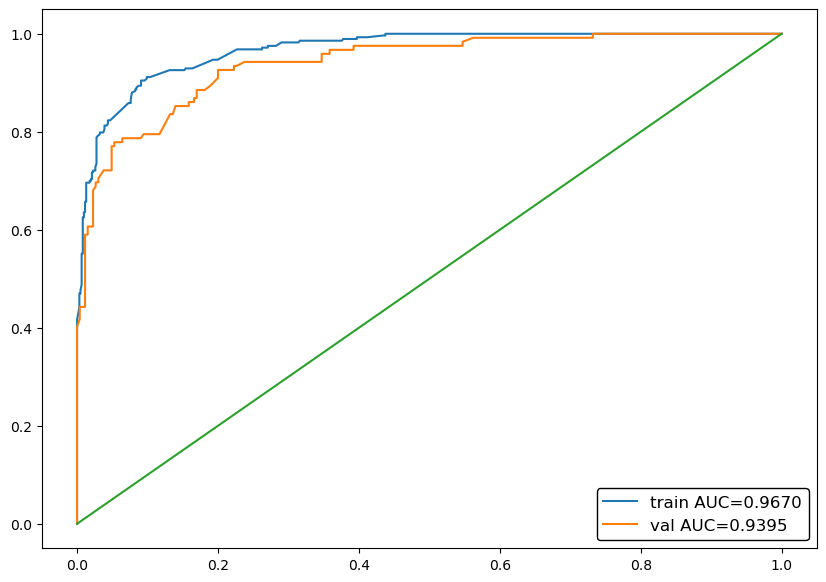

In [13]:
y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_val_predicted = boosting_model.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
val_auc = roc_auc_score(y_val, y_val_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='val AUC={:.4f}'.format(val_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [14]:
explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


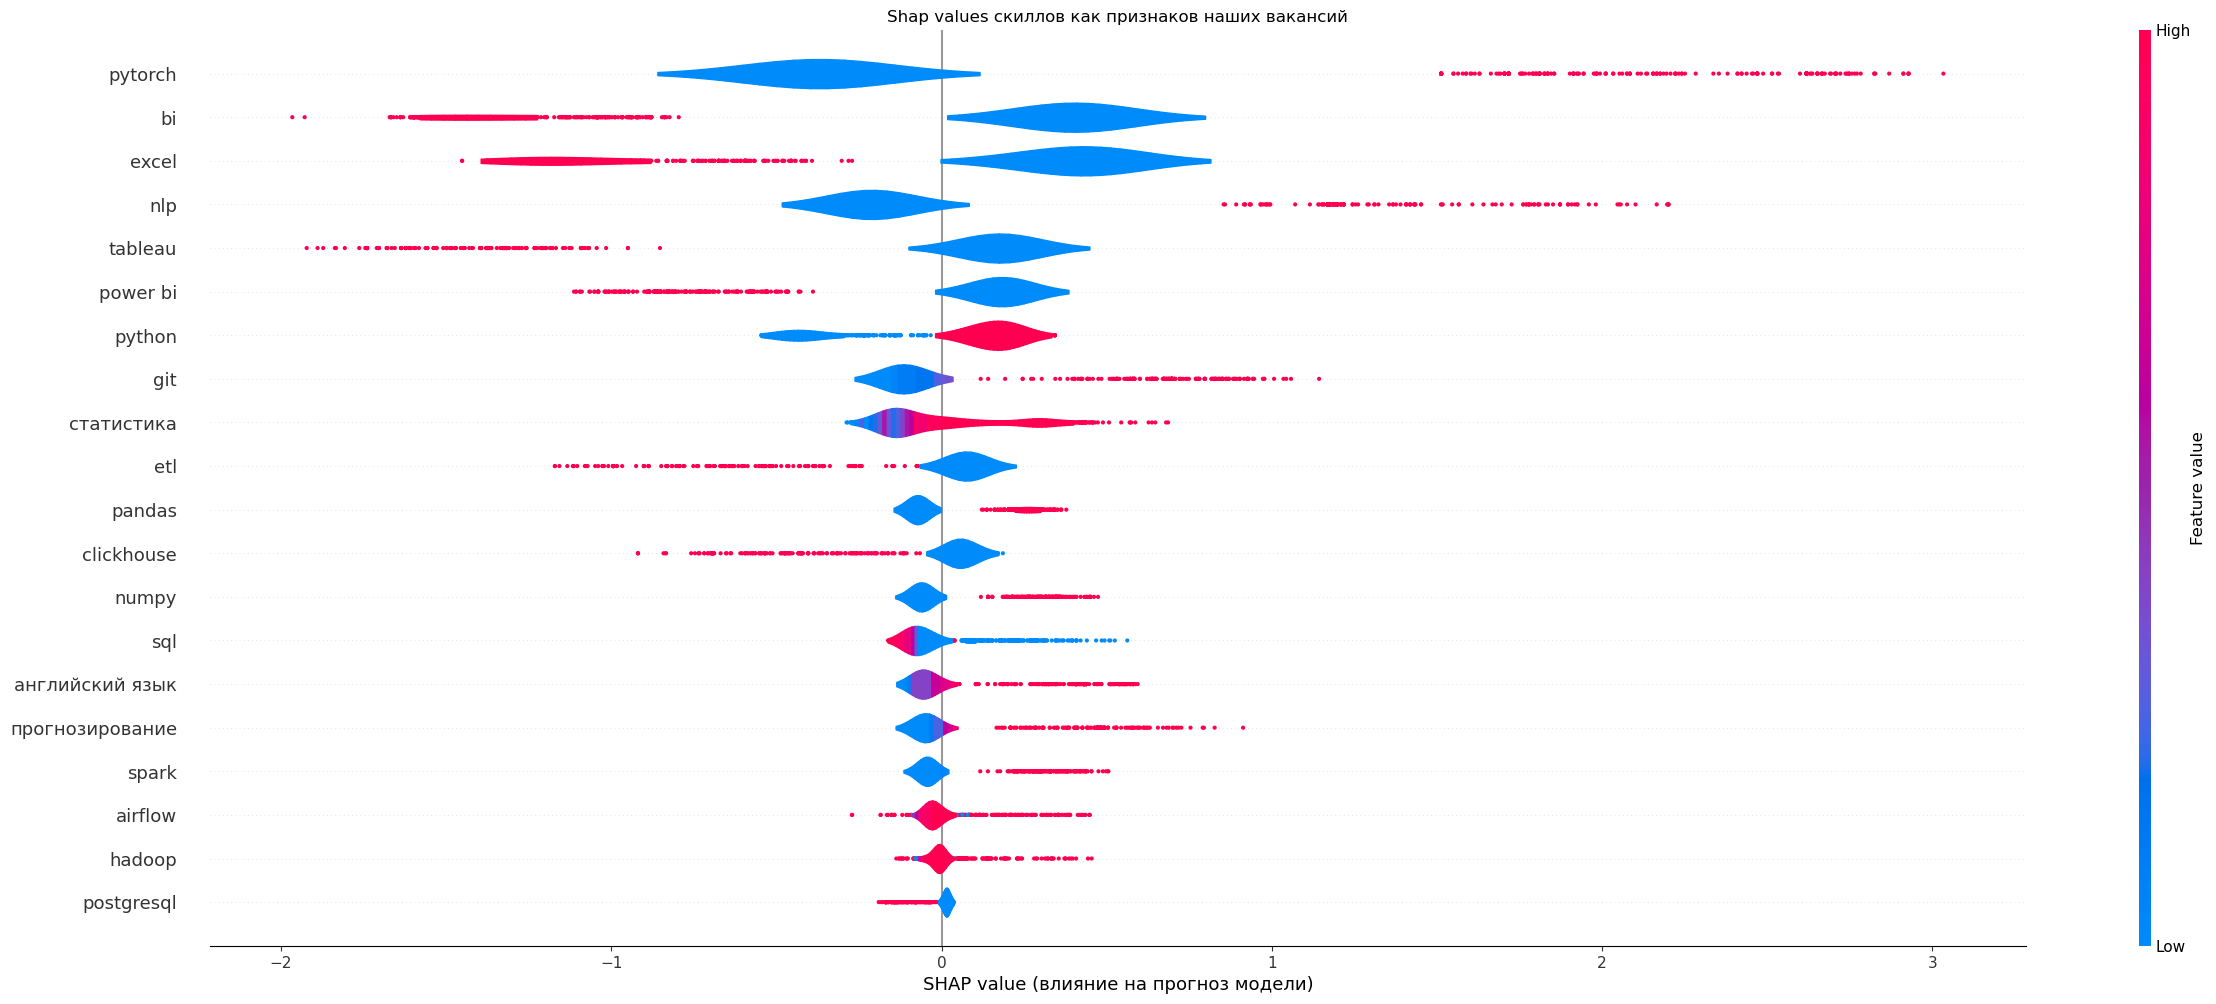

In [17]:
ax = shap.summary_plot(shap_values, X, max_display=30, plot_size=[25, 10], plot_type="violin", show=False)
plt.title("Shap values скиллов как признаков наших вакансий")
plt.xlabel('SHAP value (влияние на прогноз модели)')
plt.show()


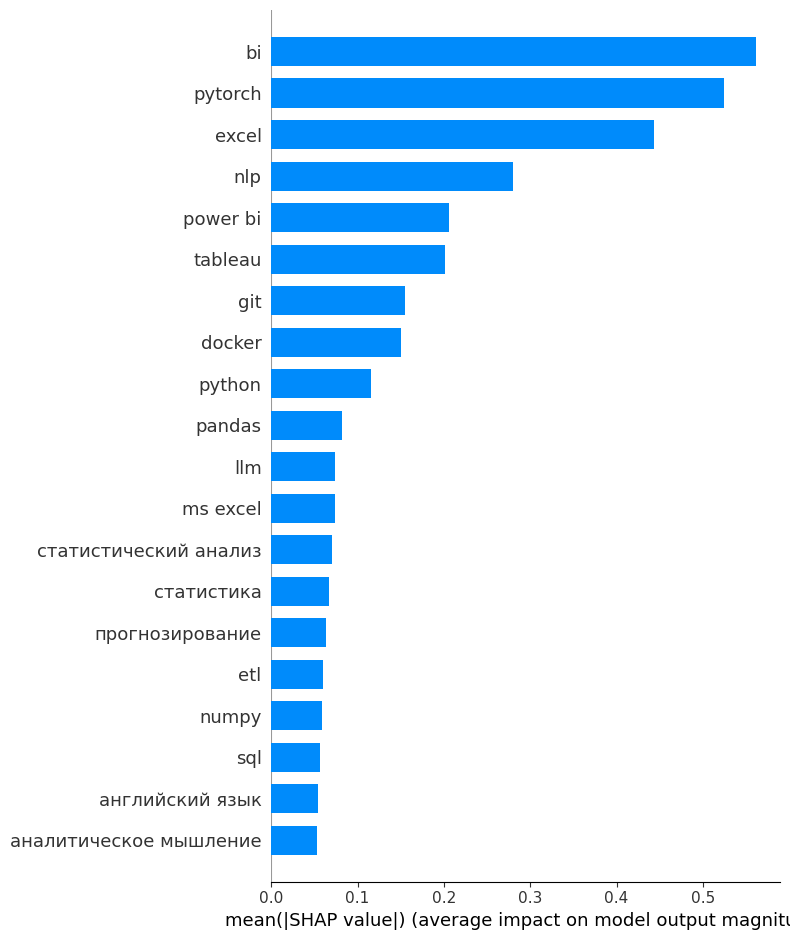

In [200]:
shap.summary_plot(shap_values, X, plot_type="bar")
